# Implementing a CNN

Now that we have heard of CNNs, let's revisit the FashionMNSIT data set and try to improve our results.

So far we have only used pre-loaded datasets. This is of course not always possible if we are dealing with real world scenarios. So let's try to see how we would create our own `Dataset` subclass.

In [1]:
!wget https://hyperion.bbirke.de/data/datasets/fashionmnist.zip
!mkdir -p datasets/fashionmnist
!unzip fashionmnist.zip -d datasets/fashionmnist/

--2024-03-11 14:09:13--  https://hyperion.bbirke.de/data/datasets/fashionmnist.zip
Resolving hyperion.bbirke.de (hyperion.bbirke.de)... 45.10.26.122
Connecting to hyperion.bbirke.de (hyperion.bbirke.de)|45.10.26.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41054414 (39M) [application/zip]
Saving to: ‘fashionmnist.zip’

fashionmnist.zip    100%[===================>]  39.15M  17.7MB/s    in 2.2s    

2024-03-11 14:09:16 (17.7 MB/s) - ‘fashionmnist.zip’ saved [41054414/41054414]

Archive:  fashionmnist.zip
  inflating: datasets/fashionmnist/fashion-mnist_test.csv  
  inflating: datasets/fashionmnist/fashion-mnist_train.csv  


The data set is split in two different `.csv` files. One for training and one for testing.

In [2]:
!ls -l datasets/fashionmnist/

total 151592
-rw-r--r-- 1 root root  22176691 Sep 21  2019 fashion-mnist_test.csv
-rw-r--r-- 1 root root 133047193 Sep 21  2019 fashion-mnist_train.csv


We can comfortably load csv files into a `pandas.DataFrame`.

In [3]:
import pandas as pd

df_train = pd.read_csv("datasets/fashionmnist/fashion-mnist_train.csv")
df_test = pd.read_csv("datasets/fashionmnist/fashion-mnist_test.csv")

Let's visualize the header and first few rows of our dataframe.

In [4]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now let's see what we need to build our own `Datset` class.

## Creating a Custom Dataset

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`. A minimal skeleton implementation would look something like this:

In [5]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

The `__init__` function is run once when instantiating the Dataset object. We initialize a data structure, containing labels and images, and both transforms.

The `__getitem__` function loads and returns a sample from the dataset at the given index idx. Based on the index, it calls the transform functions on label and image (if applicable), and returns the tensor image and corresponding label in a tuple.

The `__len__` function returns the number of samples in our dataset.

Now let's implement our Dataset.

In [6]:
import numpy as np

class FashionDataset(Dataset):

    def __init__(self, dataframe, transform = None, target_transform=None):
        self.fashion_MNIST = dataframe.values.tolist()
        self.transform = transform
        self.target_transform = target_transform

        label = []
        image = []

        for i in self.fashion_MNIST:
            # first column is our label.
            label.append(i[0])
            image.append(i[1:])

        self.labels = np.asarray(label)
        # Dimension of numpy images is [n, h, w, c] = n * 28 * 28 * 1,
        # where height = width = 28 and color_channels = 1.
        # PyTorch image tensors are of dimension [n, c, h, w],
        # where n is the minibatch size, h is the image height,
        # w is the image width, and c is the number of color channels.
        # The toTensor() transform converts the numpy array to a tensor and
        # reshapes its dimensions accordingly
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]

        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            image = self.target_transform(label)

        return image, label

Now we can create an instance of our training and test dataset.

In [7]:
from torchvision.transforms import ToTensor

training_data = FashionDataset(df_train, transform=ToTensor())
test_data = FashionDataset(df_test, transform=ToTensor())

Let's visualize a few items and corresponding labels to see if everything looks fine.

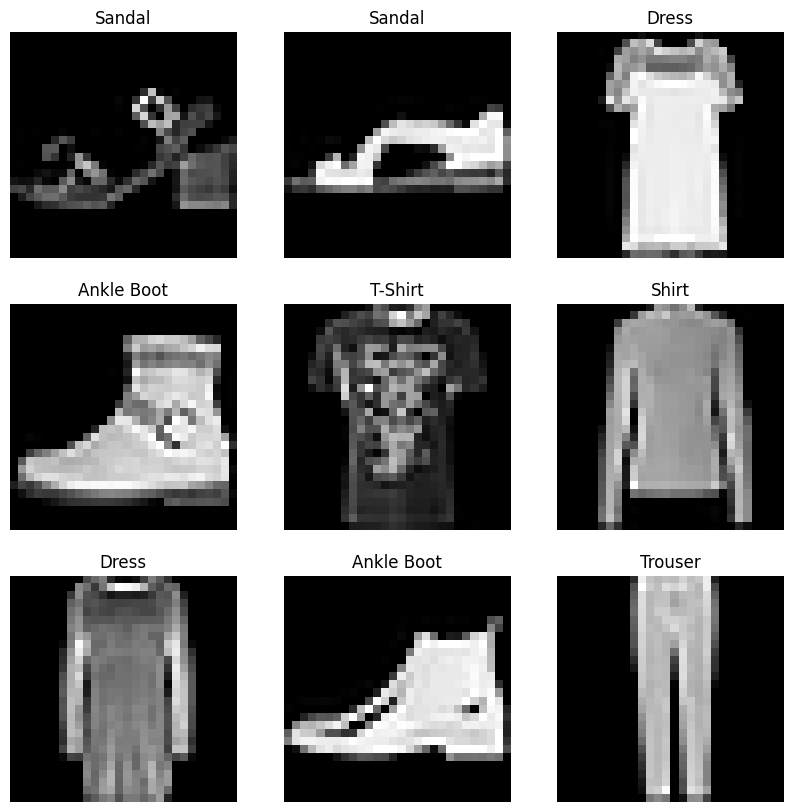

In [8]:
import matplotlib.pyplot as plt
import torch

val2label = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(val2label[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Looks good. Now we can define our hyperparameters and create our training and test Dataloader.

In [9]:
batch_size = 32
epochs = 5
learning_rate = 1e-3

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Don't forget to set your device.

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Now we can start to implement your CNN.

## Building the CNN

Lets get right into it.

In [12]:
from torch import nn

class FashionCNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=64*6*6, out_features=600),
            nn.Dropout(p=0.25),
            nn.Linear(in_features=600, out_features=120),
            nn.Linear(in_features=120, out_features=10),
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.flatten(x)
        x = self.linear_layer(x)
        return x

As we can see the CNN can be implemented in a similar fashion as our previous Neural Network. Let's look at some of the parameters.

* **in_channels**: specifies the number of channels in the input image or feature map.\
For example, if you're dealing with RGB images, the `in_channels` would be set to 3 since there are three color channels (red, green, and blue). If you're working with grayscale images, `in_channels` would be 1.
* **out_channels**: refers to the number of output channels or feature maps produced by the convolution operation.\
Each filter generates one feature map in the output. The `out_channels` parameter specifies how many of these feature maps will be produced.\
For example, if you have an input image with three channels (e.g., RGB), and you define a `Conv2d` layer with `out_channels=64`, it means that the convolution operation will produce 64 feature maps as output. Each of these feature maps represents different learned patterns or features extracted from the input image.
* **kernel_size**: specifies the size of the convolutional kernel/filter.\
For a 2D convolutional layer, the `kernel_size` can be a tuple (height, width) or integer (equals square filter with height = width) specifying the height and width of the 2D convolution window.
* **padding**: specifies the amount of padding to add to the input tensor along each spatial dimension (height and width).\
Padding refers to adding extra rows and columns of zeros around the input tensor before applying the convolution operation. This is often done to preserve spatial dimensions and ensure that the output tensor has the same spatial dimensions as the input tensor.
* **stride**: specifies the step size that the filter or kernel moves across the input data during the convolution.\
For example, if you have a 2D input image of size $5 \times 5$ and you apply a convolutional filter with a $3 \times 3$ kernel and a stride of $1$, the filter will move one pixel at a time across the image, resulting in a $3 \times 3$ output feature map.\
If you set the stride parameter to 2, the filter will move two pixels at a time.

We also added two new modules, we haven't mentioned yet: `nn.BatchNorm2d` and `nn.Dropout2d`



### Dropout

The `nn.Dropout` layer is a regularization technique commonly used in all sort of neural networks to prevent overfitting.

During training, `nn.Dropout` randomly sets a fraction of the input units to zero with probability $p$. This means that it temporarily removes some connections between neurons in the network. By doing so, it forces the network to learn a more robust representation of the data because it can't rely on any individual neuron or combination of neurons too heavily.

### Batch Normalization

Batch Normalization is a technique used in neural networks to improve the training speed, stability, and performance. It addresses the problem of internal covariate shift, which refers to the change in the distribution of network activations due to parameter updates during training. This shift can slow down training by requiring lower learning rates and careful initialization.

In simple terms, Batch Normalization normalizes the output of each layer in a neural network by adjusting and scaling the activations. This is done by normalizing the activations of each layer across the minibatch during training.

### Check Model

Now we can create an instance of our CNN and check the forward pass.

In [13]:
model = FashionCNN().to(device)

In [14]:
img, label = next(iter(train_dataloader))

img = img.to(device)
logits = model(img)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)

print(f"Predicted class: {y_pred}")

Predicted class: tensor([5, 0, 5, 5, 7, 4, 0, 0, 0, 5, 5, 0, 0, 5, 5, 0, 0, 7, 7, 0, 7, 0, 0, 0,
        0, 5, 7, 0, 0, 5, 5, 5], device='cuda:0')


## Training

The training of our CNN is almoast identicall to the previous Network. The only change is we switch to the ADAM optimization algorithm (SGD would work also).
The training and test loops are also unchanged.

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Important for batch normalization and dropout layers
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Important for batch normalization and dropout layers
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [17]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.393199  [   32/60000]
loss: 0.287054  [ 3232/60000]
loss: 0.439430  [ 6432/60000]
loss: 0.281249  [ 9632/60000]
loss: 0.457652  [12832/60000]
loss: 0.481360  [16032/60000]
loss: 0.367316  [19232/60000]
loss: 0.445594  [22432/60000]
loss: 0.454131  [25632/60000]
loss: 0.311895  [28832/60000]
loss: 0.211167  [32032/60000]
loss: 0.548130  [35232/60000]
loss: 0.323187  [38432/60000]
loss: 0.399101  [41632/60000]
loss: 0.294847  [44832/60000]
loss: 0.222667  [48032/60000]
loss: 0.270024  [51232/60000]
loss: 0.329997  [54432/60000]
loss: 0.725103  [57632/60000]
Test Error: 
 Accuracy: 88.6%, Avg loss: 0.314911 

Epoch 2
-------------------------------
loss: 0.292490  [   32/60000]
loss: 0.279129  [ 3232/60000]
loss: 0.385526  [ 6432/60000]
loss: 0.330118  [ 9632/60000]
loss: 0.296075  [12832/60000]
loss: 0.261908  [16032/60000]
loss: 0.464940  [19232/60000]
loss: 0.225283  [22432/60000]
loss: 0.197523  [25632/60000]
loss: 0.100779  [28832/60000

## Evaluation

Let's visualize some of our results.

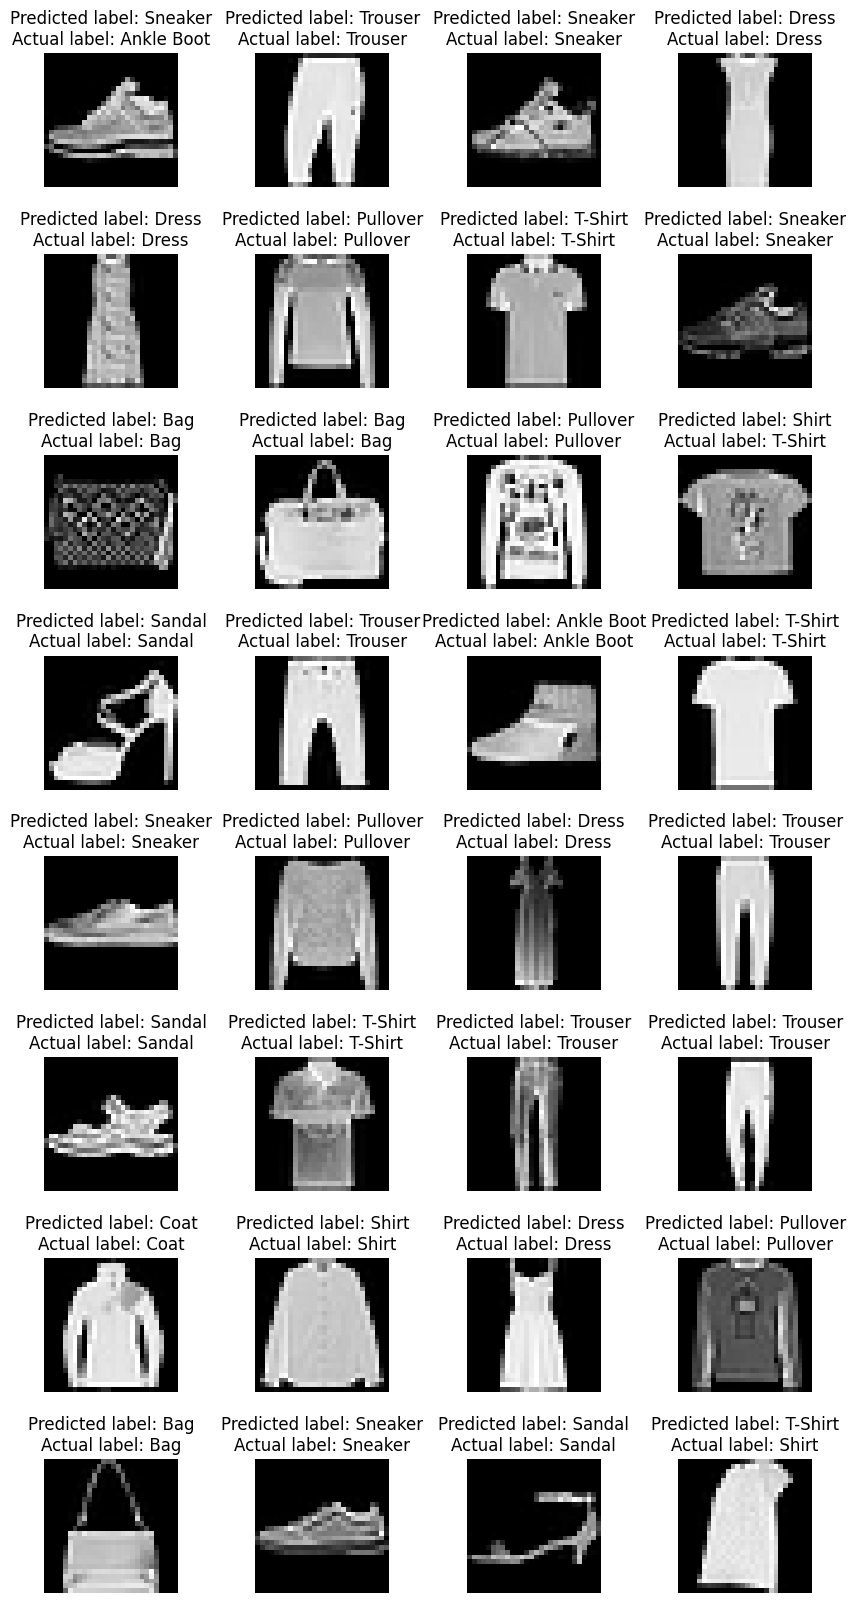

In [18]:
img, label = next(iter(test_dataloader))
img = img.to(device)
label = label.to(device)
predicted_label = model(img)

figure = plt.figure(figsize=(10, 20))
cols, rows = 4, 8
for i in range(0, cols * rows):
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f"Predicted label: {val2label[predicted_label[i].argmax().item()]}\nActual label: {val2label[label[i].item()]}")
    plt.axis("off")
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    plt.imshow(img[i].cpu().squeeze(), cmap="gray")
plt.show()

<Axes: >

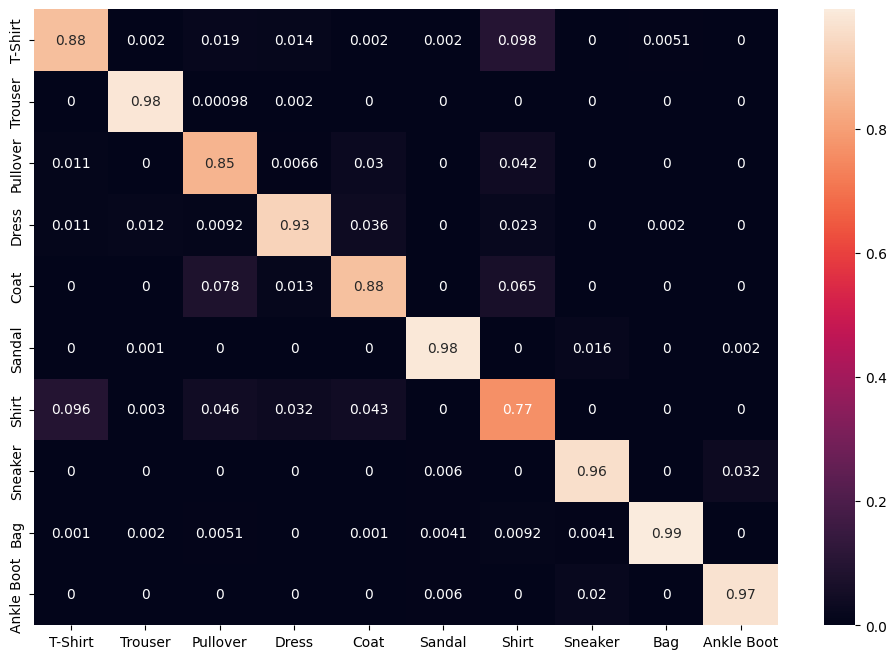

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

with torch.no_grad():
    # iterate over test data
    for X, y in test_dataloader:

            X = X.to(device)
            y = y.to(device)
            output = model(X)

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)

            labels = y.data.cpu().numpy()
            y_true.extend(labels)

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=0)[:, None], index = [val2label[i] for i in range(10)],
                     columns = [val2label[i] for i in range(10)])
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True)